In [4]:
import numpy as np

from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras.models import Model, Sequential, save_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Activation, BatchNormalization, Dropout

from matplotlib import pyplot as plt

In [5]:
def plot_history(history, params=['loss']):
    for param in params:
        plt.plot(history.history[param], label='train')
        if 'val_%s' % param in history.history.keys():
            plt.plot(history.history['val_%s' % param], label='test')
        plt.xlabel('epoch')
        plt.ylabel(param)
        plt.title(param.capitalize())
        plt.legend()
        plt.show()

In [6]:
def print_ae_results(orig, enc, dec, e_h, e_w):
    plt.figure(figsize=(20, 6))
    n = 10
        
    for i in range(n):
        idx = np.random.randint(0, orig.shape[0] - 1)
        plt.subplot(3, n, i + 1)
        plt.imshow(orig[idx].reshape(W, H), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(enc[idx].reshape(e_h, e_w), cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(dec[idx].reshape(W, H), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [7]:
def print_noisy_results(x_orig, x_noise):
    plt.figure(figsize=(20, 6))
    n = 10
        
    for i in range(n):
        idx = np.random.randint(0, x_orig.shape[0] - 1)
        plt.subplot(2, n, i + 1)
        plt.imshow(x_orig[idx].reshape(W, H), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_noise[idx].reshape(W, H), cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [8]:
W, H = 28, 28
n_channels = 1

In [20]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [21]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))

In [22]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [12]:
def build_dense_model():
    encoding_dim = 32
    input_img = Input(shape=(W * H,))
 
    encoded = Dense(128, activation='relu')(input_img)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(W * H, activation='sigmoid')(decoded)
    
    ae = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    enc_img = Input(shape=(encoding_dim,))
    
    d = ae.layers[-3](enc_img)
    d = ae.layers[-2](d)
    d = ae.layers[-1](d)
    
    decoder = Model(enc_img, d)
    
    ae.compile(optimizer='adadelta', loss='binary_crossentropy')
    return ae, encoder, decoder

In [13]:
def build_cnn_model():
    
    def build_enc():
        input_img = Input(shape=(W, H, n_channels))

        encoder = Conv2D(16, (3, 3), padding='same')(input_img)
        encoder = Activation('relu')(encoder)
        encoder = BatchNormalization()(encoder)
        encoder = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder)

        encoder = Conv2D(8, (3, 3), padding='same')(encoder)
        encoder = Activation('relu')(encoder)
        encoder = BatchNormalization()(encoder)
        encoder = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder)

        encoder = Conv2D(8, (3, 3), padding='same')(encoder)
        encoder = Activation('relu')(encoder)
        encoder = BatchNormalization()(encoder)
        encoder = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder)
        
        return Model(input_img, encoder)
    
    def build_decoder():
        enc_input = Input(shape=(4, 4, 8))
        decoder = Conv2D(8, (3, 3), padding='same')(enc_input)
        decoder = Activation('relu')(decoder)
        decoder = BatchNormalization()(decoder)
        decoder = UpSampling2D(size=(2, 2))(decoder)

        decoder = Conv2D(8, (3, 3), padding='same')(decoder)
        decoder = Activation('relu')(decoder)
        decoder = BatchNormalization()(decoder)
        decoder = UpSampling2D(size=(2, 2))(decoder)

        decoder = Conv2D(16, (3, 3))(decoder)
        decoder = Activation('relu')(decoder)
        decoder = BatchNormalization()(decoder)
        decoder = UpSampling2D(size=(2, 2))(decoder)        
        decoder = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

        return Model(enc_input, decoder)
    
    enc = build_enc()
    dec = build_decoder()
    input_img = Input(shape=(W, H, n_channels))
    ae = Model(input_img, dec(enc(input_img)))
    
    ae.compile(optimizer='adadelta', loss='binary_crossentropy')
    return ae, enc, dec

In [14]:
def build_denoising_cnn_model():
        def build_enc():
            input_img = Input(shape=(W, H, n_channels))

            encoder = Conv2D(32, (3, 3), padding='same')(input_img)
            encoder = Activation('relu')(encoder)
            encoder = BatchNormalization()(encoder)
            encoder = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder)

            encoder = Conv2D(32, (3, 3), padding='same')(encoder)
            encoder = Activation('relu')(encoder)
            encoder = BatchNormalization()(encoder)
            encoder = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder)

            return Model(input_img, encoder)
    
        def build_decoder():
            enc_input = Input(shape=(7, 7, 32))
            decoder = Conv2D(32, (3, 3), padding='same')(enc_input)
            decoder = Activation('relu')(decoder)
            decoder = BatchNormalization()(decoder)
            decoder = UpSampling2D(size=(2, 2))(decoder)

            decoder = Conv2D(32, (3, 3), padding='same')(decoder)
            decoder = Activation('relu')(decoder)
            decoder = BatchNormalization()(decoder)
            decoder = UpSampling2D(size=(2, 2))(decoder)

            decoder = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(decoder)

            return Model(enc_input, decoder)
    
        enc = build_enc()
        dec = build_decoder()
        input_img = Input(shape=(W, H, n_channels))
        ae = Model(input_img, dec(enc(input_img)))

        ae.compile(optimizer='adadelta', loss='binary_crossentropy')
        return ae, enc, dec

In [123]:
ae, encoder, decoder = build_dense_model()
print('AUTOENCODER')
ae.summary()
print('ENCODER')
encoder.summary()
print('DECODER')
decoder.summary()

AUTOENCODER
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_42 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_43 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_44 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_45 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_46 (Dense)             (None, 784)               101136   

In [77]:
history = ae.fit(x_train, x_train,
          batch_size=256, 
          epochs=100, 
          shuffle=True,
          validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 124us/step - loss: 0.3383 - val_loss: 0.2631
Epoch 2/100
60000/60000 [==============================] - 7s 109us/step - loss: 0.2494 - val_loss: 0.2335
Epoch 3/100
60000/60000 [==============================] - 7s 109us/step - loss: 0.2278 - val_loss: 0.2224
Epoch 4/100
60000/60000 [==============================] - 7s 113us/step - loss: 0.2157 - val_loss: 0.2035
Epoch 5/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.1985 - val_loss: 0.1905
Epoch 6/100
60000/60000 [==============================] - 7s 123us/step - loss: 0.1867 - val_loss: 0.1791
Epoch 7/100
60000/60000 [==============================] - 8s 127us/step - loss: 0.1781 - val_loss: 0.1736
Epoch 8/100
60000/60000 [==============================] - 8s 125us/step - loss: 0.1716 - val_loss: 0.1673
Epoch 9/100
60000/60000 [==============================] - 8s 128us/step - loss: 0.1664 - val_

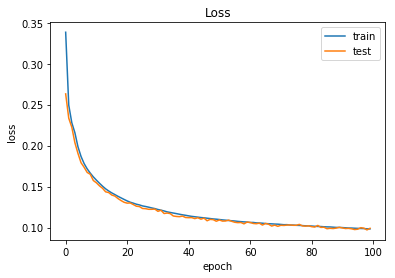

In [82]:
plot_history(history)

In [78]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

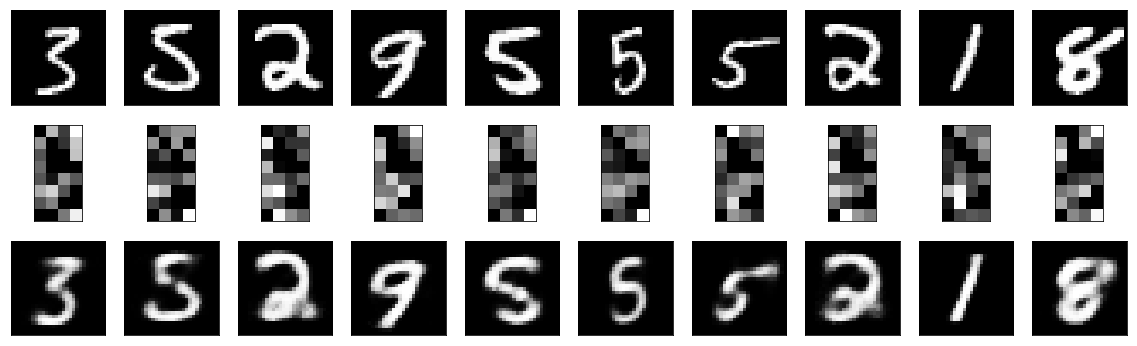

In [75]:
# After 50 epochs
print_ae_results(x_test, encoded_imgs, decoded_imgs, 8, 4)

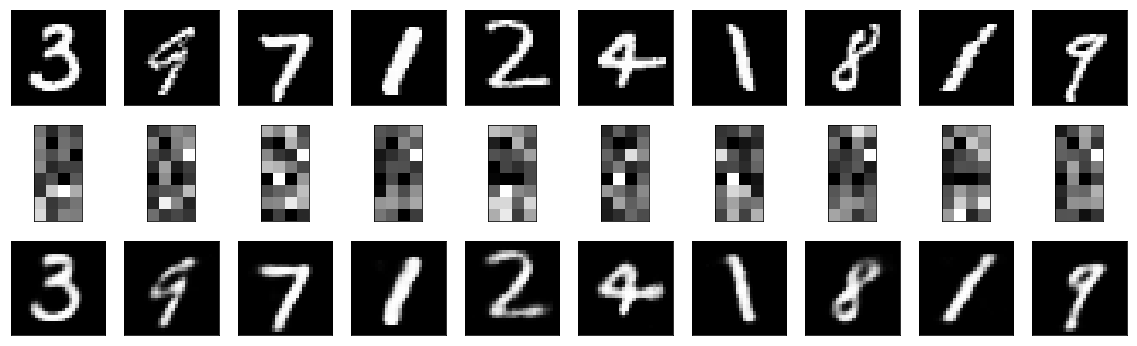

In [83]:
# After 100 epochs
print_ae_results(x_test, encoded_imgs, decoded_imgs, 8, 4)

In [23]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [24]:
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [14]:
ae, encoder, decoder = build_cnn_model()
print('AUTOENCODER')
ae.summary()
print('ENCODER')
encoder.summary()
print('DECODER')
decoder.summary()

AUTOENCODER
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 4, 4, 8)           2032      
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         2609      
Total params: 4,641
Trainable params: 4,513
Non-trainable params: 128
_________________________________________________________________
ENCODER
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
____________________________________________________

In [15]:
tb = TensorBoard(log_dir='logs', write_graph=True, write_images=True)

In [16]:
history = ae.fit(x_train, x_train,
          epochs=20, 
          shuffle=True,
          validation_data=(x_test, x_test),
          batch_size=128,
          callbacks=[tb])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 131s 2ms/step - loss: 0.2301 - val_loss: 0.1508
Epoch 2/20
60000/60000 [==============================] - 126s 2ms/step - loss: 0.1391 - val_loss: 0.1321
Epoch 3/20
60000/60000 [==============================] - 118s 2ms/step - loss: 0.1270 - val_loss: 0.1282
Epoch 4/20
60000/60000 [==============================] - 120s 2ms/step - loss: 0.1204 - val_loss: 0.1174
Epoch 5/20
60000/60000 [==============================] - 119s 2ms/step - loss: 0.1164 - val_loss: 0.1117
Epoch 6/20
60000/60000 [==============================] - 122s 2ms/step - loss: 0.1138 - val_loss: 0.1199
Epoch 7/20
60000/60000 [==============================] - 125s 2ms/step - loss: 0.1115 - val_loss: 0.1129
Epoch 8/20
60000/60000 [==============================] - 124s 2ms/step - loss: 0.1099 - val_loss: 0.1084
Epoch 9/20
60000/60000 [==============================] - 122s 2ms/step - loss: 0.1084 - val_loss: 0.1

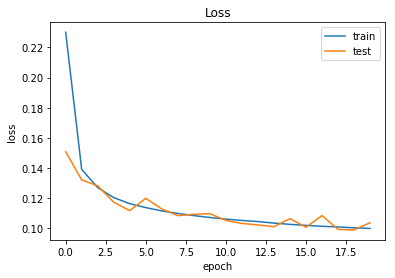

In [17]:
plot_history(history)

In [18]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

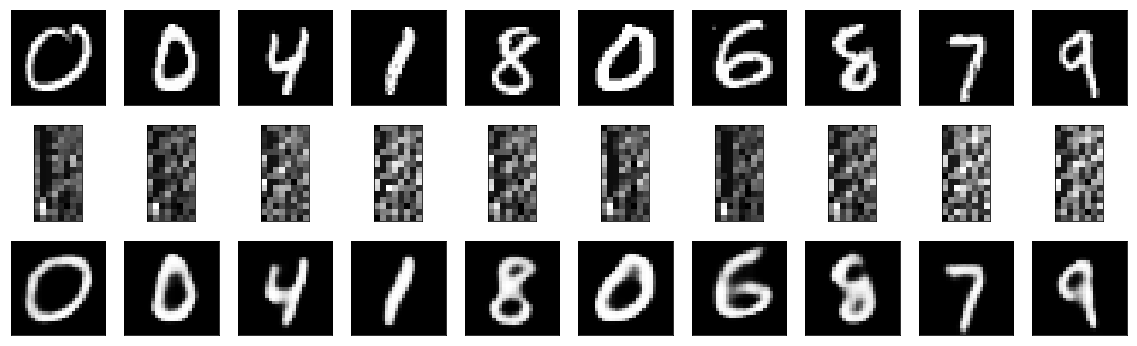

In [19]:
print_ae_results(x_test, encoded_imgs, decoded_imgs, 16, 8)

In [25]:
x_train_noisy = x_train + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + 0.5 * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

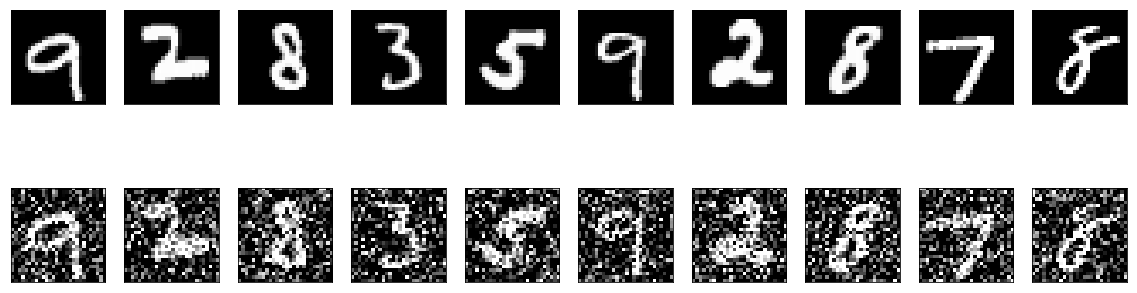

In [26]:
print_noisy_results(x_train, x_train_noisy)

In [27]:
ae, encoder, decoder = build_denoising_cnn_model()
print('AUTOENCODER')
ae.summary()
print('ENCODER')
encoder.summary()
print('DECODER')
decoder.summary()

AUTOENCODER
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
model_4 (Model)              (None, 7, 7, 32)          9824      
_________________________________________________________________
model_5 (Model)              (None, 28, 28, 1)         19041     
Total params: 28,865
Trainable params: 28,609
Non-trainable params: 256
_________________________________________________________________
ENCODER
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
__________________________________________________

In [28]:
tb = TensorBoard(log_dir='logs', write_graph=True, write_images=True)

In [29]:
history = ae.fit(x_train_noisy, x_train,
          epochs=20, 
          shuffle=True,
          validation_data=(x_test_noisy, x_test),
          batch_size=128,
          callbacks=[tb])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 322s 5ms/step - loss: 0.1611 - val_loss: 0.1152
Epoch 2/20
60000/60000 [==============================] - 319s 5ms/step - loss: 0.1082 - val_loss: 0.1049
Epoch 3/20
60000/60000 [==============================] - 249s 4ms/step - loss: 0.1042 - val_loss: 0.1070
Epoch 4/20
60000/60000 [==============================] - 247s 4ms/step - loss: 0.1024 - val_loss: 0.1004
Epoch 5/20
60000/60000 [==============================] - 248s 4ms/step - loss: 0.1014 - val_loss: 0.0993
Epoch 6/20
60000/60000 [==============================] - 247s 4ms/step - loss: 0.1004 - val_loss: 0.1011
Epoch 7/20
60000/60000 [==============================] - 251s 4ms/step - loss: 0.0998 - val_loss: 0.0988
Epoch 8/20
60000/60000 [==============================] - 248s 4ms/step - loss: 0.0993 - val_loss: 0.0976
Epoch 9/20
60000/60000 [==============================] - 248s 4ms/step - loss: 0.0989 - val_loss: 0.0

In [31]:
save_model(ae, 'ae_denoising.hdf5')

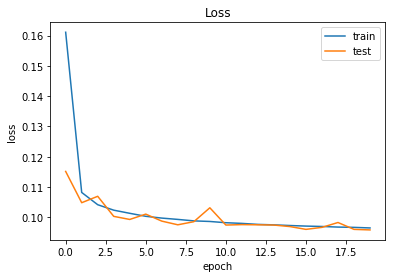

In [32]:
plot_history(history)

In [34]:
encoded_noise = encoder.predict(x_test_noisy)
decoded_noise = decoder.predict(encoded_noise)

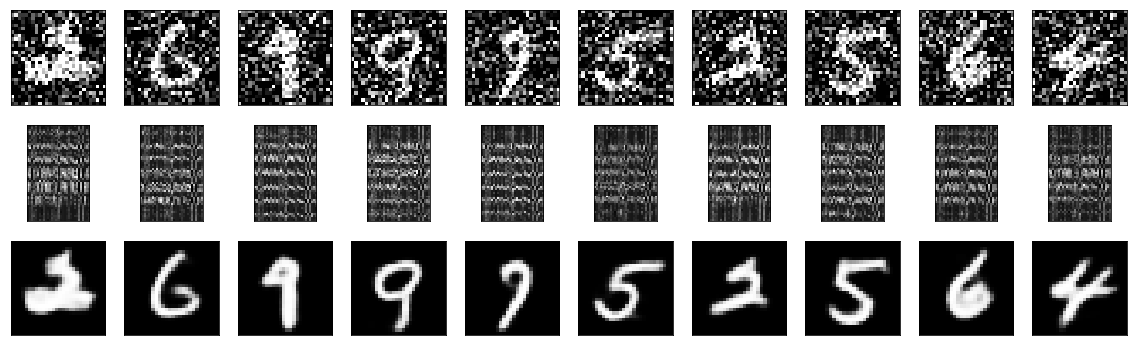

In [37]:
print_ae_results(x_test_noisy, encoded_noise, decoded_noise, 49, 32)